# CNN for Classification: Cats vs. Dogs

![catvsdog](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*qejv1I-FYujIjqev.jpg)

dataset source: https://www.microsoft.com/en-us/download/details.aspx?id=54765


## Import images

In [1]:
path = "../../data/kagglecatsanddogs_5340/PetImages"

In [2]:
import tensorflow as tf

In [ ]:
import os, sys, shutil

# Move and organise data
def create_dataset_directories(base_dir: str) -> None:
    print("Start creation of dataset directories...")

    if not os.path.exists(base_dir):
        os.mkdir(base_dir)

    directories = ["train", "validation", "test"]
    for directory in directories:
        sub_dir = os.path.join(base_dir, directory)
        os.mkdir(sub_dir)
        os.mkdir(os.path.join(sub_dir, "cats"))
        os.mkdir(os.path.join(sub_dir, "dogs"))

    print("Done")


def copy_data(
    src: str, dst: str, example_name: str, fnames: list[str]
) -> None:
    print("Copying...")
    for fname in fnames:
        print(f"Copying {fname} to {dst}")
        shutil.copyfile(
            os.path.join(src, fname),
            os.path.join(dst, example_name + "." + fname)
        )


In [ ]:
import re
fnames_cats = [f for f in os.listdir(path + "/Cat") if re.match(r'[0-9]+.*\.jpg', f)]
fnames_dogs = [f for f in os.listdir(path + "/Dog") if re.match(r'[0-9]+.*\.jpg', f)]

In [ ]:
len(fnames_dogs)

In [ ]:
12500*0.8

In [ ]:
train_fnames_cats = fnames_cats[:8000]
val_fnames_cats = fnames_cats[8000:10000]
test_fnames_cats = fnames_cats[10000:]

train_fnames_dogs = fnames_dogs[:8000]
val_fnames_dogs = fnames_dogs[8000:10000]
test_fnames_dogs = fnames_dogs[10000:]

In [6]:
destination = "../../data/cats_vs_dogs"

In [ ]:
create_dataset_directories(destination)

copy_data(path + "/Cat", f"{destination}/train/cats/", "cat", train_fnames_cats)
copy_data(path + "/Dog", f"{destination}/train/dogs/", "dog", train_fnames_dogs)

copy_data(path + "/Cat", f"{destination}/validation/cats/", "cat", val_fnames_cats)
copy_data(path + "/Dog", f"{destination}/validation/dogs/", "dog", val_fnames_dogs)

copy_data(path + "/Cat", f"{destination}/test/cats/", "cat", test_fnames_cats)
copy_data(path + "/Dog", f"{destination}/test/dogs/", "dog", test_fnames_dogs)


## Remove corrupted images

In [ ]:
import shutil
import os
import time
from PIL import Image

# Method 1
def extract_corrupt_img_files(dir_path):
  """
  Gets corrupted image files within a directory
  
    Arguments:
        dir_path: a string representing the path for the target directory

    Returns:
        a list of the paths for the corrupted image files

  """ 
  i = 0
  beg = time.time()
  corrupted = []
  for filename in os.listdir(dir_path):
    i +=1
    if (i % 50 == 0):
      print(i, end =" ")
    if (i % 1000 == 0):
      print()
    try:
      img = Image.open(dir_path + '/' + filename)
    except:
      corrupted.append(filename)
      os.remove(dir_path + '/' + filename)
      continue

  end = time.time()
  print()
  print('*' * 50) 
  print("\nTASK FINISHED IN " + str(end - beg) + " seconds ")
  print("{} corrupted files found and removed in {}".format(len(corrupted), dir_path))
  print('*' * 50) 
  return corrupted

extract_corrupt_img_files(f"{destination}/test/cats/")

In [ ]:
from pathlib import Path
import imghdr

# Method 2

data_dir = f"{destination}/test/dogs/"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image and will be removed")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow and will be removed")
            os.remove(filepath)


In [ ]:
from pathlib import Path
import imghdr
test_dir = f"{destination}/test/"
validation_dir = f"{destination}/validation/"
train_dir = f"{destination}/train/"

# Method 3

img_link=list(Path(test_dir).glob(r'**/*.jpg'))

count_num=0
for lnk in img_link:
    binary_img=open(lnk,'rb')
    find_img=tf.compat.as_bytes('JFIF') in binary_img.peek(10)#The JFIF is a JPEG File Interchange Format (JFIF). It is a standard which we gauge if an image is corrupt or substandard
    if not find_img:
        count_num+=1
        os.remove(str(lnk))
print('Total %d pcs image delete from Dataset' % count_num)

In [ ]:
import glob
# Method 4

img_paths = glob.glob(os.path.join(f"{destination}/train/",'*/*.*')) # assuming you point to the directory containing the label folders.

bad_paths = []

for image_path in img_paths:
    try:
      img_bytes = tf.io.read_file(image_path)
      decoded_img = tf.io.decode_image(img_bytes)
    except tf.errors.InvalidArgumentError as e:
      print(f"Found bad path {image_path}...{e}")
      bad_paths.append(image_path)
      os.remove(image_path)
    
    #print(f"{image_path}: OK")

print("BAD PATHS (removed):")
for bad_path in bad_paths:
    print(f"{bad_path}")

### Build your model

In [3]:
from keras import layers
from keras import models


model = models.Sequential([
    layers.Conv2D(
        32, (3, 3), activation="relu",
        input_shape=(150, 150, 3)
    ),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation="relu"),

    layers.Dense(1, activation="sigmoid")
])

model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",  # https://optimization.cbe.cornell.edu/index.php?title=RMSProp
    metrics=["accuracy"]
)

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [7]:
from keras.preprocessing.image import ImageDataGenerator
# process the data

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = f"{destination}/train/"
validation_dir = f"{destination}/validation/"

batch_size=32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode="binary"
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode="binary"
)

Found 14997 images belonging to 2 classes.
Found 3706 images belonging to 2 classes.


In [8]:
14997 / batch_size

468.65625

In [9]:
len(train_generator)

469

In [10]:
epochs = 15
len(train_generator) // epochs

31

In [11]:
# model sees each data point once
epochs = 15
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator) // epochs,  # len(train_generator)//epochs
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator) // epochs
)

Epoch 1/15
31/31 [==============================] - 10s 310ms/step - loss: 0.8570 - accuracy: 0.4849 - val_loss: 0.6890 - val_accuracy: 0.6250
Epoch 2/15
31/31 [==============================] - 9s 288ms/step - loss: 0.6979 - accuracy: 0.5373 - val_loss: 0.6885 - val_accuracy: 0.6027
Epoch 3/15
31/31 [==============================] - 9s 293ms/step - loss: 0.7152 - accuracy: 0.4919 - val_loss: 0.6940 - val_accuracy: 0.4420
Epoch 4/15
31/31 [==============================] - 9s 296ms/step - loss: 0.7078 - accuracy: 0.5232 - val_loss: 0.6778 - val_accuracy: 0.6205
Epoch 5/15
31/31 [==============================] - 9s 286ms/step - loss: 0.6934 - accuracy: 0.5341 - val_loss: 0.6707 - val_accuracy: 0.5625
Epoch 6/15
31/31 [==============================] - 9s 288ms/step - loss: 0.7044 - accuracy: 0.5556 - val_loss: 0.6755 - val_accuracy: 0.5402
Epoch 7/15
31/31 [==============================] - 10s 318ms/step - loss: 0.6499 - accuracy: 0.6210 - val_loss: 0.7204 - val_accuracy: 0.5580
Epoc

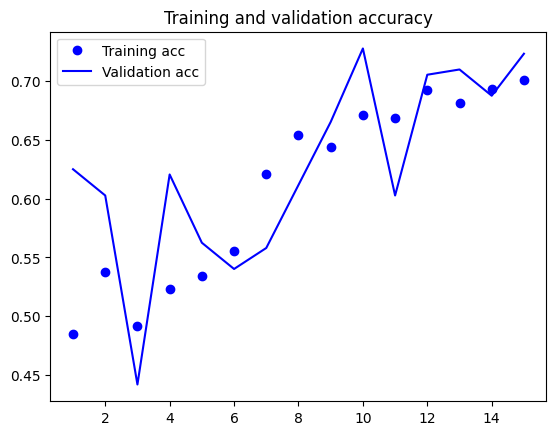

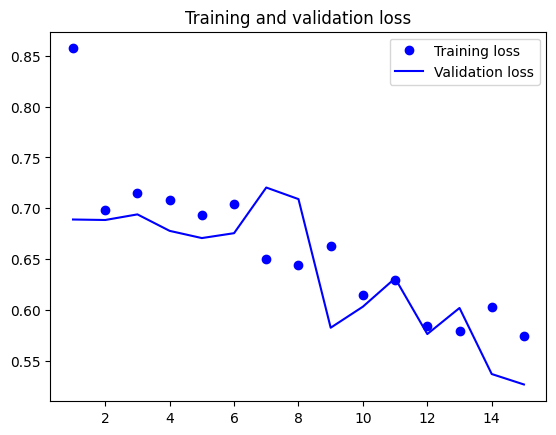

In [12]:
import matplotlib.pyplot as plt


acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")

plt.legend()
plt.show()

## Data Augmentation

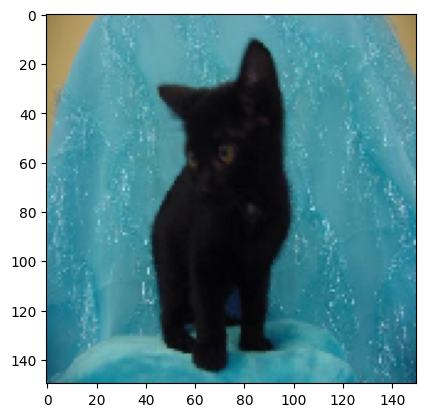

In [13]:
# deprecated
import os

import matplotlib.pyplot as plt

from more_itertools import take
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_cats_dir = f"{destination}/train/cats/"

fnames = [
    os.path.join(train_cats_dir, fname)
    for fname in os.listdir(train_cats_dir)
]

img_path = fnames[92]
img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
plt.imshow(image.array_to_img(x[0]))

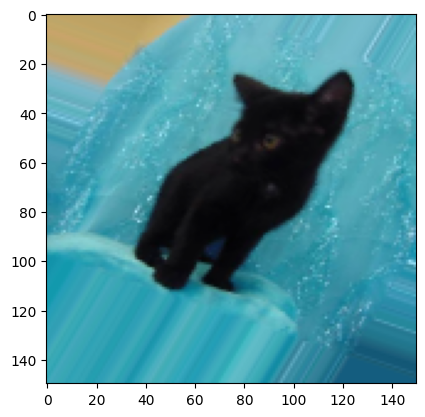

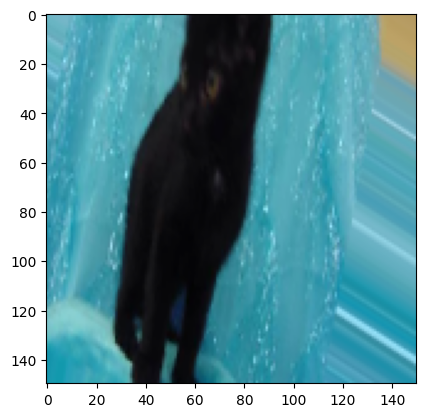

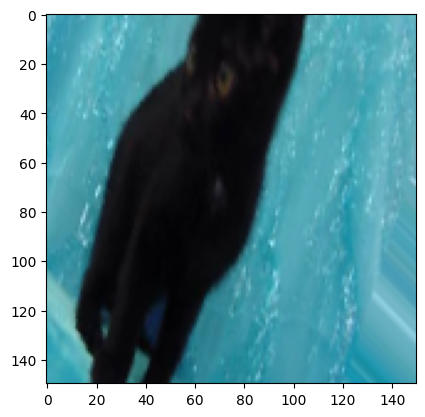

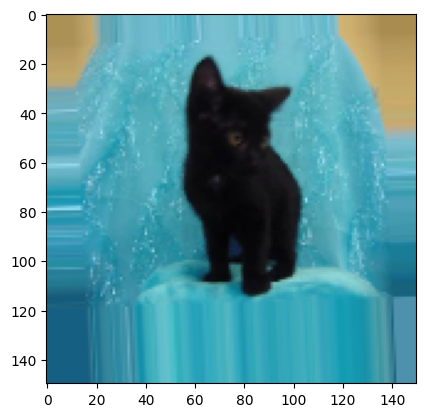

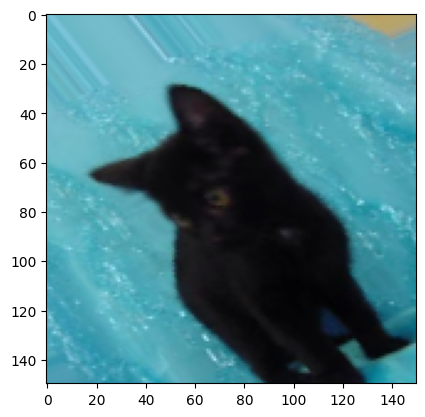

In [14]:
for batch in take(5, datagen.flow(x, batch_size=1)):
    plt.figure()
    imgplot = plt.imshow(image.array_to_img(batch[0]))

plt.show()

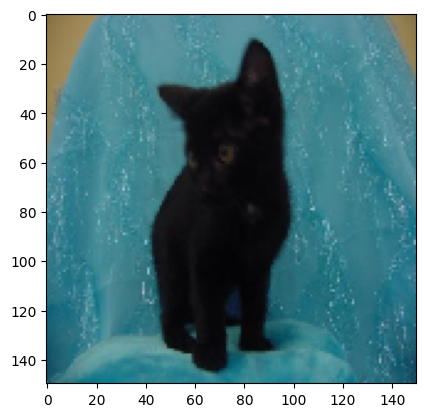

In [15]:
# keras preprocessing layers
import tensorflow as tf

IMG_SIZE = 150

# You can use the Keras preprocessing layers to resize your images to a consistent shape 
# (with tf.keras.layers.Resizing), and to rescale pixel values (with tf.keras.layers.Rescaling)

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

result = resize_and_rescale(x)
_ = plt.imshow(result[0])

In [16]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 0.87843144


In [17]:
# You can use the Keras preprocessing layers for data augmentation as well, 
# such as tf.keras.layers.RandomFlip and tf.keras.layers.RandomRotation.

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [18]:
result[0]

<tf.Tensor: shape=(150, 150, 3), dtype=float32, numpy=
array([[[0.5137255 , 0.427451  , 0.24313727],
        [0.5254902 , 0.43921572, 0.25490198],
        [0.53333336, 0.44705886, 0.2627451 ],
        ...,
        [0.5411765 , 0.45882356, 0.28235295],
        [0.5294118 , 0.44705886, 0.27058825],
        [0.52156866, 0.43921572, 0.25490198]],

       [[0.5176471 , 0.43137258, 0.24705884],
        [0.5294118 , 0.4431373 , 0.25882354],
        [0.5411765 , 0.454902  , 0.27058825],
        ...,
        [0.5411765 , 0.45882356, 0.28235295],
        [0.53333336, 0.45098042, 0.27450982],
        [0.5254902 , 0.4431373 , 0.25882354]],

       [[0.52156866, 0.43529415, 0.2509804 ],
        [0.53333336, 0.44705886, 0.2627451 ],
        [0.54901963, 0.46274513, 0.2784314 ],
        ...,
        [0.54509807, 0.46274513, 0.28627452],
        [0.5372549 , 0.454902  , 0.2784314 ],
        [0.53333336, 0.45098042, 0.27450982]],

       ...,

       [[0.05882353, 0.30588236, 0.37254903],
        [0.10

In [19]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(result[0], 0), tf.float32)

In [20]:
image

<tf.Tensor: shape=(1, 150, 150, 3), dtype=float32, numpy=
array([[[[0.5137255 , 0.427451  , 0.24313727],
         [0.5254902 , 0.43921572, 0.25490198],
         [0.53333336, 0.44705886, 0.2627451 ],
         ...,
         [0.5411765 , 0.45882356, 0.28235295],
         [0.5294118 , 0.44705886, 0.27058825],
         [0.52156866, 0.43921572, 0.25490198]],

        [[0.5176471 , 0.43137258, 0.24705884],
         [0.5294118 , 0.4431373 , 0.25882354],
         [0.5411765 , 0.454902  , 0.27058825],
         ...,
         [0.5411765 , 0.45882356, 0.28235295],
         [0.53333336, 0.45098042, 0.27450982],
         [0.5254902 , 0.4431373 , 0.25882354]],

        [[0.52156866, 0.43529415, 0.2509804 ],
         [0.53333336, 0.44705886, 0.2627451 ],
         [0.54901963, 0.46274513, 0.2784314 ],
         ...,
         [0.54509807, 0.46274513, 0.28627452],
         [0.5372549 , 0.454902  , 0.2784314 ],
         [0.53333336, 0.45098042, 0.27450982]],

        ...,

        [[0.05882353, 0.30588236, 

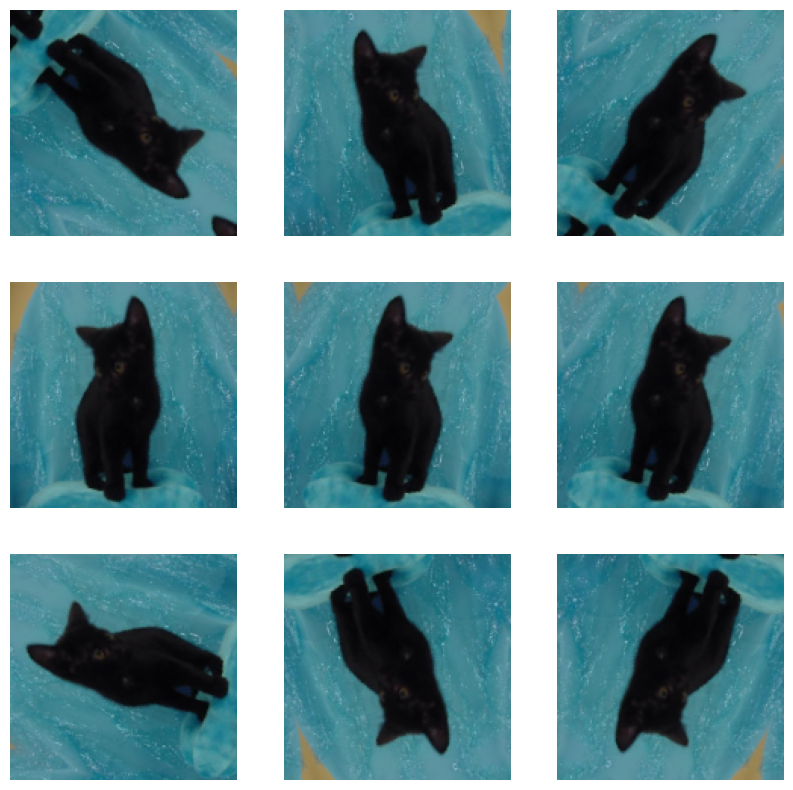

In [21]:
# https://machinelearningmastery.com/image-augmentation-with-keras-preprocessing-layers-and-tf-image/

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [22]:
# add the preprocessing layers to the model

#There are two important points to be aware of in this case:

# 1. Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.
# 2. When you export your model using model.save, the preprocessing layers will be saved along with the rest of your model. 
# If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). 
# This can save you from the effort of having to reimplement that logic server-side.


# You will see some improvement in accuracy if you remove the RandomFlip and RandomRotation layers 
# because you make the problem easier. However, as you want the network to predict well on a wide variation 
# of image quality and properties, using augmentation can help your resulting network become more powerful.

# https://machinelearningmastery.com/image-augmentation-with-keras-preprocessing-layers-and-tf-image/

model_augmented = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(
        32, (3, 3), activation="relu",
        input_shape=(150, 150, 3)
    ),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation="relu"),

    layers.Dense(1, activation="sigmoid")
])

model_augmented.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)


In [23]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(150,150),
    batch_size=batch_size,
    color_mode="rgb"
)
#train_data = train_data.repeat(2)

validation_data = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(150,150),
    batch_size=batch_size,
    color_mode="rgb"
)


Found 14997 files belonging to 2 classes.
Found 3706 files belonging to 2 classes.


In [24]:
type(train_data)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [25]:
# train_data.file_paths
train_data.class_names

['cats', 'dogs']

In [26]:
epochs = 15
history = model_augmented.fit(
    train_data,
    steps_per_epoch=len(train_data)//epochs,
    epochs=epochs,
    validation_data=validation_data
)

Epoch 1/15
31/31 [==============================] - ETA: 0s - loss: 1.0323 - accuracy: 0.5202

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 20s 607ms/step - loss: 1.0323 - accuracy: 0.5202 - val_loss: 0.7090 - val_accuracy: 0.5008
Epoch 2/15
31/31 [==============================] - ETA: 0s - loss: 0.7351 - accuracy: 0.5383

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 19s 627ms/step - loss: 0.7351 - accuracy: 0.5383 - val_loss: 0.6861 - val_accuracy: 0.5273
Epoch 3/15
31/31 [==============================] - ETA: 0s - loss: 0.6907 - accuracy: 0.5675

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 18s 592ms/step - loss: 0.6907 - accuracy: 0.5675 - val_loss: 0.6823 - val_accuracy: 0.5005
Epoch 4/15
23/31 [=====================>........] - ETA: 2s - loss: 0.6949 - accuracy: 0.5476

31/31 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.5484

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 17s 544ms/step - loss: 0.6911 - accuracy: 0.5484 - val_loss: 0.8019 - val_accuracy: 0.4992
Epoch 5/15
31/31 [==============================] - ETA: 0s - loss: 0.7110 - accuracy: 0.5645

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 17s 548ms/step - loss: 0.7110 - accuracy: 0.5645 - val_loss: 0.6757 - val_accuracy: 0.5785
Epoch 6/15
31/31 [==============================] - ETA: 0s - loss: 0.6814 - accuracy: 0.5726

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 17s 542ms/step - loss: 0.6814 - accuracy: 0.5726 - val_loss: 0.6905 - val_accuracy: 0.5658
Epoch 7/15
 7/31 [=====>........................] - ETA: 6s - loss: 0.6975 - accuracy: 0.5223

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


25/31 [=======================>......] - ETA: 1s - loss: 0.7027 - accuracy: 0.5400

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


31/31 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5554

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 17s 548ms/step - loss: 0.6929 - accuracy: 0.5554 - val_loss: 0.7211 - val_accuracy: 0.5151
Epoch 8/15
31/31 [==============================] - ETA: 0s - loss: 0.6954 - accuracy: 0.5625

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 16s 541ms/step - loss: 0.6954 - accuracy: 0.5625 - val_loss: 0.6635 - val_accuracy: 0.5809
Epoch 9/15
31/31 [==============================] - ETA: 0s - loss: 0.6802 - accuracy: 0.5726

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 17s 550ms/step - loss: 0.6802 - accuracy: 0.5726 - val_loss: 0.6570 - val_accuracy: 0.6533
Epoch 10/15
31/31 [==============================] - ETA: 0s - loss: 0.6687 - accuracy: 0.5998

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 17s 542ms/step - loss: 0.6687 - accuracy: 0.5998 - val_loss: 0.6337 - val_accuracy: 0.6579
Epoch 11/15
31/31 [==============================] - ETA: 0s - loss: 0.6757 - accuracy: 0.5988

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 17s 542ms/step - loss: 0.6757 - accuracy: 0.5988 - val_loss: 0.6791 - val_accuracy: 0.5747
Epoch 12/15
31/31 [==============================] - ETA: 0s - loss: 0.6584 - accuracy: 0.5948

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 17s 549ms/step - loss: 0.6584 - accuracy: 0.5948 - val_loss: 0.6132 - val_accuracy: 0.6686
Epoch 13/15
31/31 [==============================] - ETA: 0s - loss: 0.6840 - accuracy: 0.6482

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 16s 541ms/step - loss: 0.6840 - accuracy: 0.6482 - val_loss: 0.6229 - val_accuracy: 0.6608
Epoch 14/15
 8/31 [======>.......................] - ETA: 5s - loss: 0.6477 - accuracy: 0.6328

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


26/31 [========================>.....] - ETA: 1s - loss: 0.6218 - accuracy: 0.6647

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


31/31 [==============================] - ETA: 0s - loss: 0.6322 - accuracy: 0.6562

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 17s 547ms/step - loss: 0.6322 - accuracy: 0.6562 - val_loss: 0.6287 - val_accuracy: 0.6473
Epoch 15/15
31/31 [==============================] - ETA: 0s - loss: 0.6355 - accuracy: 0.6704

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 17s 542ms/step - loss: 0.6355 - accuracy: 0.6704 - val_loss: 0.6402 - val_accuracy: 0.6436


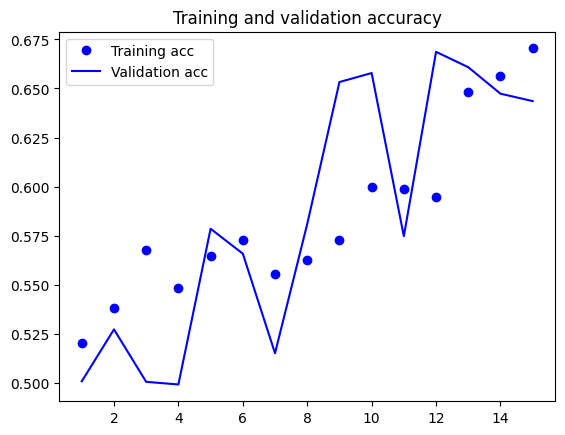

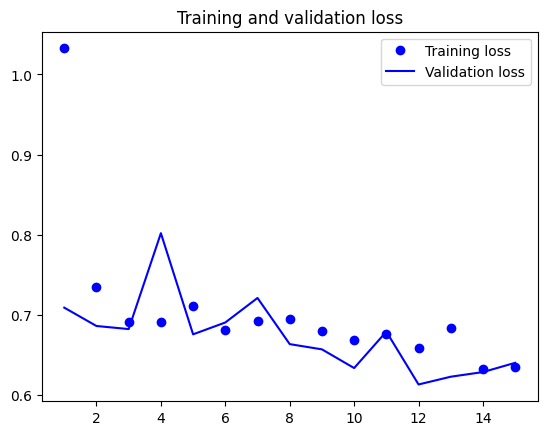

In [28]:
import matplotlib.pyplot as plt


acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")

plt.legend()
plt.show()

In [29]:
test_dir = f"{destination}/test/"
test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(150,150),
    batch_size=batch_size,
    color_mode="rgb"
)

Found 4689 files belonging to 2 classes.


In [30]:
model.evaluate(test_data)

  5/147 [>.............................] - ETA: 11s - loss: 47.7988 - accuracy: 0.5938

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 10/147 [=>............................] - ETA: 11s - loss: 49.6362 - accuracy: 0.5969

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 19/147 [==>...........................] - ETA: 10s - loss: 42.6212 - accuracy: 0.6431

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 55/147 [==========>...................] - ETA: 7s - loss: 39.0029 - accuracy: 0.6580

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


104/147 [====================>.........] - ETA: 3s - loss: 37.3742 - accuracy: 0.6608

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


147/147 [==============================] - 13s 84ms/step - loss: 38.6091 - accuracy: 0.6560


[38.609073638916016, 0.6560034155845642]

In [31]:
model_augmented.evaluate(test_data)

  4/147 [..............................] - ETA: 11s - loss: 0.6845 - accuracy: 0.6016

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 10/147 [=>............................] - ETA: 11s - loss: 0.6614 - accuracy: 0.6438

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 19/147 [==>...........................] - ETA: 10s - loss: 0.6688 - accuracy: 0.6349

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 55/147 [==========>...................] - ETA: 7s - loss: 0.6441 - accuracy: 0.6420

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


104/147 [====================>.........] - ETA: 3s - loss: 0.6374 - accuracy: 0.6478

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


147/147 [==============================] - 13s 85ms/step - loss: 0.6367 - accuracy: 0.6451


[0.6366645693778992, 0.6451268792152405]

In [32]:
# data loading and preprocessing must be the same as in training!
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode="binary"
)
model.evaluate(test_generator)

Found 4689 images belonging to 2 classes.
147/147 [==============================] - 13s 86ms/step - loss: 0.5450 - accuracy: 0.7202


[0.5449516177177429, 0.7201961874961853]

1/1 [==============================] - 0s 14ms/step


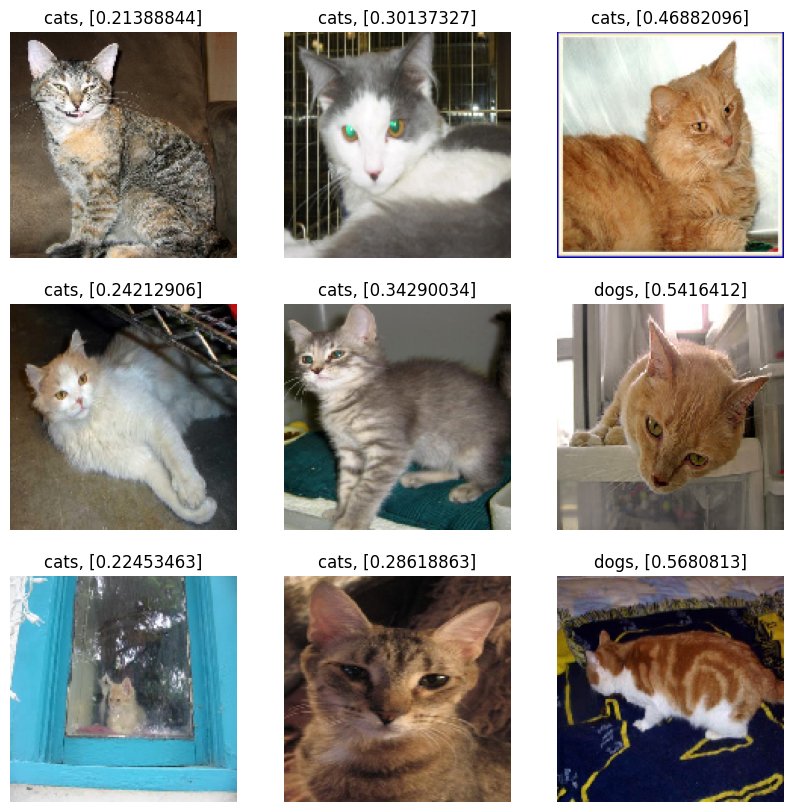

In [35]:
from keras.preprocessing import image

fnames = [
    os.path.join(test_dir + "/cats", fname)
    for fname in os.listdir(test_dir + "/cats")
]

plt.figure(figsize=(10, 10))
for i in range(9):
  img_path = fnames[i]
  img = image.load_img(img_path, target_size=(150, 150))

  x = image.img_to_array(img)
  x = x.reshape((1,) + x.shape)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image.array_to_img(x[0]))
  prediction = model_augmented.predict(x)[0]
  predicted_lable = test_data.class_names[1] if prediction > 0.5 else test_data.class_names[0]
  plt.title(f"{predicted_lable}, {prediction}")
  plt.axis("off")


In [34]:
test_data.class_names[1]

'dogs'

In [36]:
# Create a confusion_matrix
import numpy as np

predictions = np.array([])
labels =  np.array([])
for x, y in test_data:
  prediction=model_augmented.predict(x) 
  classes_x=tf.constant((prediction > 0.5).astype("int32").reshape(1, -1)[0])
  predictions = np.concatenate([predictions, classes_x])
  labels = np.concatenate([labels, y])

print(len(labels))
print(len(predictions))
confusion_martix = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
confusion_martix

1/1 [==============================] - 0s 80ms/step


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 80ms/step


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 81ms/step


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 90ms/step


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 80ms/step


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1/1 [==============================] - 0s 49ms/step
4689
4689


array([[2054,  314],
       [1350,  971]], dtype=int32)

tf.Tensor(
[[2054  314]
 [1350  971]], shape=(2, 2), dtype=int32)


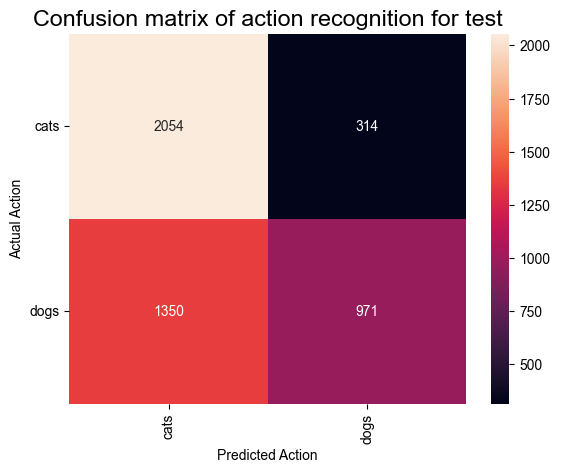

In [37]:
import seaborn as sns
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  print(cm)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(6, 6)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

plot_confusion_matrix(labels, predictions, test_data.class_names, 'test')

# ResNet (Residual Neural Network) 
Deeper networks are harder to optimize. With each extra layer that we add to a network, we add more difficulty in the process of training; it becomes harder for the optimization algorithm that we use to find the right parameters. As we add more layers, the network gets better results until at some point; then as we continue to add extra layers, the accuracy starts to drop.

https://www.neuralception.com/objectdetection-batchnorm/#residual-networks


![resnet](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*cIKFeG7ZIl9D-VnSF0KAZA.png)
https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba

**How does the information flow through the skip connection?**
The skip connections, also known as shortcut connections, are active during both the forward pass and the backward pass (during backpropagation) in a ResNet architecture.

- During the forward pass:

The input data passes through the convolutional layers within a residual block.
Simultaneously, the input data also flows through the skip connection, which directly connects the input of the residual block to its output.

- During the backward pass (during backpropagation):

Gradients are computed with respect to the loss function and propagated backward through the network.
The gradients flow through both the convolutional layers and the skip connections.
The gradients that flow through the skip connections help alleviate the vanishing gradient problem by providing a direct path for gradient flow from the output to the input of the residual block.
By maintaining the skip connections throughout both the forward and backward passes, ResNet architectures enable easier optimization of deep networks and facilitate the training of very deep architectures effectively.


**Why use ResNet and not just simplify the network?**

- ResNets use skip connections to **preserve information flow** throughout the network. By directly connecting earlier layers to later layers, ResNets mitigate the risk of information loss or distortion as it passes through multiple layers. Simply removing layers doesn't address this issue.
- Removing layers without considering the network architecture can lead to degradation in performance as the depth increases. ResNets, on the other hand, **ensure that gradients can flow freely through the network**, making it easier to train deep architectures without suffering from vanishing gradients.
- The skip connections in ResNets enable feature reuse, allowing **earlier layers to directly contribute to the output of deeper layers**. This can be beneficial for tasks where certain low-level features are relevant across different parts of the network. 

Epoch 1/10
25/25 [==============================] - 1s 14ms/step - loss: 2.3119 - accuracy: 0.0938 - val_loss: 2.3013 - val_accuracy: 0.1200
Epoch 2/10
25/25 [==============================] - 0s 14ms/step - loss: 2.3007 - accuracy: 0.1100 - val_loss: 2.3015 - val_accuracy: 0.0900
Epoch 3/10
25/25 [==============================] - 0s 11ms/step - loss: 2.2761 - accuracy: 0.1325 - val_loss: 2.2991 - val_accuracy: 0.0950
Epoch 4/10
25/25 [==============================] - 0s 12ms/step - loss: 2.1635 - accuracy: 0.1550 - val_loss: 2.3183 - val_accuracy: 0.0900
Epoch 5/10
25/25 [==============================] - 0s 10ms/step - loss: 2.1328 - accuracy: 0.1787 - val_loss: 2.3870 - val_accuracy: 0.0900
Epoch 6/10
25/25 [==============================] - 0s 11ms/step - loss: 2.0330 - accuracy: 0.2113 - val_loss: 2.6347 - val_accuracy: 0.0850
Epoch 7/10
25/25 [==============================] - 0s 11ms/step - loss: 1.9395 - accuracy: 0.2500 - val_loss: 2.9084 - val_accuracy: 0.1100
Epoch 8/10
25

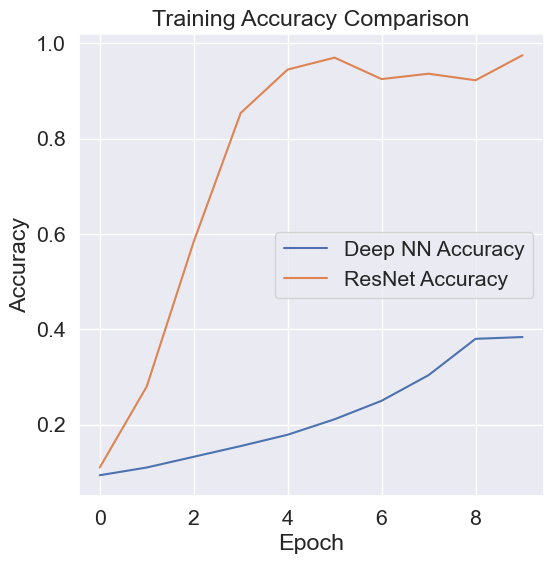

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Define a simple deep neural network
# TODO: make it deeper
def build_deep_nn():
    model = models.Sequential()
    model.add(layers.Dense(512, activation='relu', input_shape=(784,)))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    return model

# Define a ResNet-like deep neural network
def build_resnet():
    input_layer = layers.Input(shape=(784,))
    x = layers.Dense(512, activation='relu')(input_layer)
    for _ in range(10):  # Adding 10 residual blocks
        residual = x  # residual = F(x) - x  # різниця
        # two stacked blocks
        x = layers.Dense(512, activation='relu')(x)
        x = layers.Dense(512, activation=None)(x)  # No activation after the second layer, https://stats.stackexchange.com/questions/623551/no-activation-function-between-two-convolutional-layers-in-munit
        x = layers.Add()([x, residual])  # Adding the shortcut connection
        x = layers.Activation('relu')(x)
    output_layer = layers.Dense(10, activation='softmax')(x)
    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

# Generate synthetic data
num_samples = 1000
input_data = np.random.randn(num_samples, 784)
labels = np.random.randint(0, 10, size=(num_samples,))

# Build and compile the deep neural network
deep_nn = build_deep_nn()
deep_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the deep neural network
deep_nn_history = deep_nn.fit(input_data, labels, epochs=10, batch_size=32, validation_split=0.2)

# Build and compile the ResNet-like neural network
resnet = build_resnet()
resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the ResNet-like neural network
resnet_history = resnet.fit(input_data, labels, epochs=10, batch_size=32, validation_split=0.2)

# Plot the training history
plt.plot(deep_nn_history.history['accuracy'], label='Deep NN Accuracy')
plt.plot(resnet_history.history['accuracy'], label='ResNet Accuracy')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [39]:
from tensorflow.keras import layers, models

# Define the residual block
def residual_block(x, filters, kernel_size):
    shortcut = x
    
    # First convolutional layer
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)  # https://www.neuralception.com/objectdetection-batchnorm/#:~:text=In%20summary%2C%20batch%20normalization%20is,normalization%20offers%20some%20regularization%20effect.
    x = layers.Activation('relu')(x)
    
    # Second convolutional layer
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Add the shortcut connection
    if shortcut.shape[-1] != filters:  # If number of channels is not equal, apply 1x1 convolution to match dimensions
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)
    x = layers.add([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

# Build the model using residual layers
input_layer = layers.Input(shape=(150, 150, 3))
x = layers.Conv2D(32, (3, 3), activation="relu")(input_layer)
x = layers.MaxPooling2D((2, 2))(x)

# Add residual blocks
x = residual_block(x, filters=64, kernel_size=(3, 3))
x = layers.MaxPooling2D((2, 2))(x)

x = residual_block(x, filters=128, kernel_size=(3, 3))
x = layers.MaxPooling2D((2, 2))(x)

x = residual_block(x, filters=128, kernel_size=(3, 3))
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
output_layer = layers.Dense(1, activation="sigmoid")(x)

# Create model
model_res_net = models.Model(inputs=input_layer, outputs=output_layer)


In [40]:
model_res_net.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint
# No checkpoints used here because they would result from training on part of the data

epochs = 15

history = model_res_net.fit(
    train_data,
    steps_per_epoch=len(train_data)//epochs,
    epochs=epochs,
    validation_data=validation_data,
)

Epoch 1/15
31/31 [==============================] - ETA: 0s - loss: 69.8899 - accuracy: 0.4849

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 50s 2s/step - loss: 69.8899 - accuracy: 0.4849 - val_loss: 17.5943 - val_accuracy: 0.5008
Epoch 2/15
31/31 [==============================] - ETA: 0s - loss: 1.4291 - accuracy: 0.5746

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 48s 2s/step - loss: 1.4291 - accuracy: 0.5746 - val_loss: 0.7578 - val_accuracy: 0.5588
Epoch 3/15
31/31 [==============================] - ETA: 0s - loss: 0.9298 - accuracy: 0.5948

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 46s 1s/step - loss: 0.9298 - accuracy: 0.5948 - val_loss: 1.4985 - val_accuracy: 0.5003
Epoch 4/15
23/31 [=====================>........] - ETA: 5s - loss: 0.8719 - accuracy: 0.5435

31/31 [==============================] - ETA: 0s - loss: 0.8437 - accuracy: 0.5534

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 45s 1s/step - loss: 0.8437 - accuracy: 0.5534 - val_loss: 1.0378 - val_accuracy: 0.5478
Epoch 5/15
31/31 [==============================] - ETA: 0s - loss: 0.8265 - accuracy: 0.5938

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 48s 2s/step - loss: 0.8265 - accuracy: 0.5938 - val_loss: 0.9906 - val_accuracy: 0.4989
Epoch 6/15
31/31 [==============================] - ETA: 0s - loss: 0.7762 - accuracy: 0.5635

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 46s 2s/step - loss: 0.7762 - accuracy: 0.5635 - val_loss: 0.7846 - val_accuracy: 0.6149
Epoch 7/15
 7/31 [=====>........................] - ETA: 17s - loss: 0.6927 - accuracy: 0.5714

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


25/31 [=======================>......] - ETA: 4s - loss: 0.7503 - accuracy: 0.5763

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


31/31 [==============================] - ETA: 0s - loss: 0.7373 - accuracy: 0.5837

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 48s 2s/step - loss: 0.7373 - accuracy: 0.5837 - val_loss: 0.7919 - val_accuracy: 0.6144
Epoch 8/15
31/31 [==============================] - ETA: 0s - loss: 0.7506 - accuracy: 0.5988

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 46s 2s/step - loss: 0.7506 - accuracy: 0.5988 - val_loss: 0.7507 - val_accuracy: 0.5793
Epoch 9/15
31/31 [==============================] - ETA: 0s - loss: 0.7617 - accuracy: 0.6190

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 46s 2s/step - loss: 0.7617 - accuracy: 0.6190 - val_loss: 0.7250 - val_accuracy: 0.5772
Epoch 10/15
31/31 [==============================] - ETA: 0s - loss: 0.6734 - accuracy: 0.6361

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 48s 2s/step - loss: 0.6734 - accuracy: 0.6361 - val_loss: 0.7364 - val_accuracy: 0.6098
Epoch 11/15
31/31 [==============================] - ETA: 0s - loss: 0.6900 - accuracy: 0.6381

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 52s 2s/step - loss: 0.6900 - accuracy: 0.6381 - val_loss: 0.7592 - val_accuracy: 0.5599
Epoch 12/15
31/31 [==============================] - ETA: 0s - loss: 0.7171 - accuracy: 0.6300

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 48s 2s/step - loss: 0.7171 - accuracy: 0.6300 - val_loss: 0.6325 - val_accuracy: 0.6654
Epoch 13/15
31/31 [==============================] - ETA: 0s - loss: 0.6418 - accuracy: 0.6593

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 48s 2s/step - loss: 0.6418 - accuracy: 0.6593 - val_loss: 0.7788 - val_accuracy: 0.5529
Epoch 14/15
 8/31 [======>.......................] - ETA: 17s - loss: 0.5675 - accuracy: 0.7266

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


26/31 [========================>.....] - ETA: 3s - loss: 0.5719 - accuracy: 0.7127

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


31/31 [==============================] - ETA: 0s - loss: 0.5790 - accuracy: 0.6996

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 48s 2s/step - loss: 0.5790 - accuracy: 0.6996 - val_loss: 0.6038 - val_accuracy: 0.6967
Epoch 15/15
31/31 [==============================] - ETA: 0s - loss: 0.6262 - accuracy: 0.6845

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


31/31 [==============================] - 48s 2s/step - loss: 0.6262 - accuracy: 0.6845 - val_loss: 0.6596 - val_accuracy: 0.6719


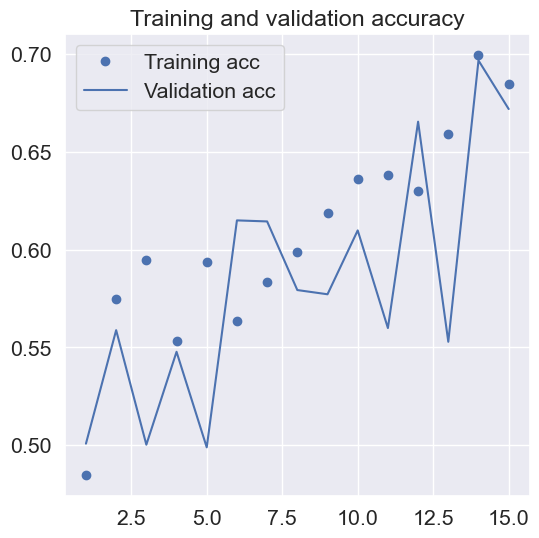

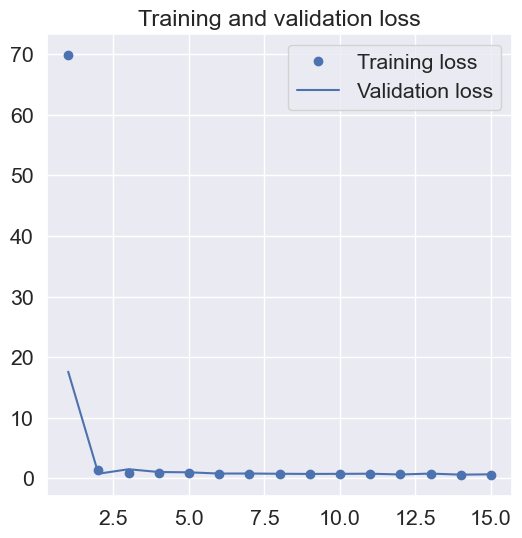

In [42]:
import matplotlib.pyplot as plt


acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")

plt.legend()
plt.show()

In [43]:
model_res_net.save("res_net.keras")

In [44]:
model_res_net.evaluate(test_data)

  2/147 [..............................] - ETA: 43s - loss: 0.6950 - accuracy: 0.6875

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


  9/147 [>.............................] - ETA: 32s - loss: 0.6457 - accuracy: 0.6875

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 18/147 [==>...........................] - ETA: 29s - loss: 0.6516 - accuracy: 0.6823

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 53/147 [=========>....................] - ETA: 21s - loss: 0.6593 - accuracy: 0.6910

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 9s - loss: 0.6349 - accuracy: 0.6817 

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


147/147 [==============================] - 33s 220ms/step - loss: 0.6587 - accuracy: 0.6761


[0.6586840748786926, 0.6760503053665161]

ResNet Versions:
https://medium.com/mlearning-ai/a-quick-overview-of-resnet-models-f8ed277ae81e

# Pretrained models

In [45]:
from tensorflow.keras.models import load_model
model_res_net = load_model("res_net.keras")
model_res_net.layers

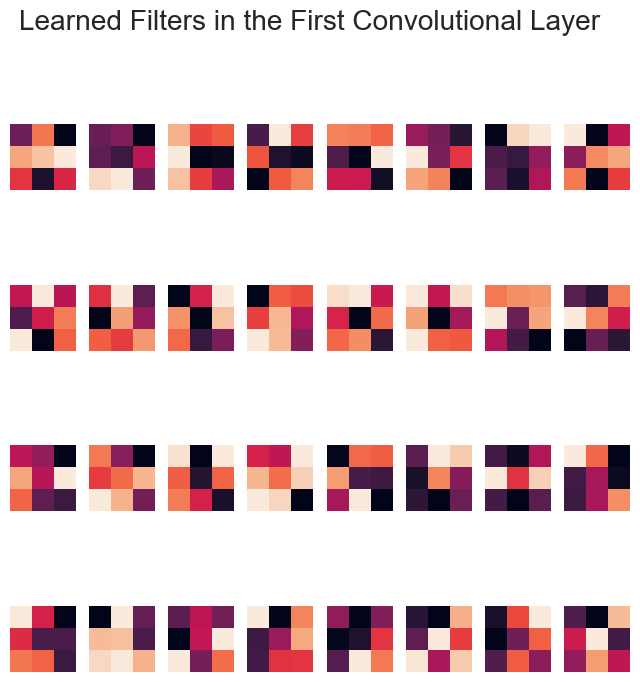

In [46]:
# Extract the filters from the first convolutional layer - feature extraction!
filters = model_res_net.layers[1].get_weights()[0]

# Visualize the learned filters
# Learned Filters:
# The first part of the code visualizes the learned filters from the first convolutional layer. Each filter is a small matrix 
# of weights that slides over the input image, capturing different features.

plt.figure(figsize=(8, 8))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(filters[:, :, 0, i])
    plt.axis('off')
plt.suptitle('Learned Filters in the First Convolutional Layer')
plt.show()


In [47]:
from tensorflow.keras.applications import ResNet50
ResNet_50 = ResNet50(weights=None)
# parameter number: 
ResNet_50.count_params()

25636712

In [48]:
ResNet_50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

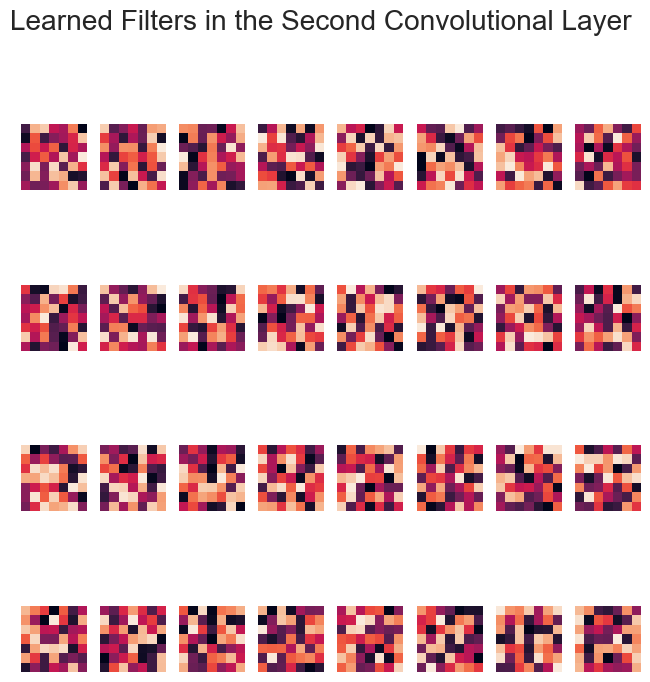

In [49]:
# Extract the filters from the second convolutional layer
filters = ResNet_50.layers[2].get_weights()[0]

# Visualize the learned filters
# Learned Filters:
# The first part of the code visualizes the learned filters from the first convolutional layer. Each filter is a small matrix 
# of weights that slides over the input image, capturing different features.

plt.figure(figsize=(8, 8))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(filters[:, :, 0, i])
    plt.axis('off')
plt.suptitle('Learned Filters in the Second Convolutional Layer')
plt.show()

In [50]:
# Pretrained model on ImageNet https://www.image-net.org
# https://paperswithcode.com/dataset/imagenet
# based on https://wordnet.princeton.edu
# The most highly-used subset of ImageNet is the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) 2012-2017 image classification and localization dataset. 
# This dataset spans 1000 object classes and contains 1,281,167 training images, 50,000 validation images and 100,000 test images.

from tensorflow import keras
pretrained_resnet50 = keras.applications.ResNet50(
    weights="imagenet",
    classes=1000,
    classifier_activation="softmax",
)

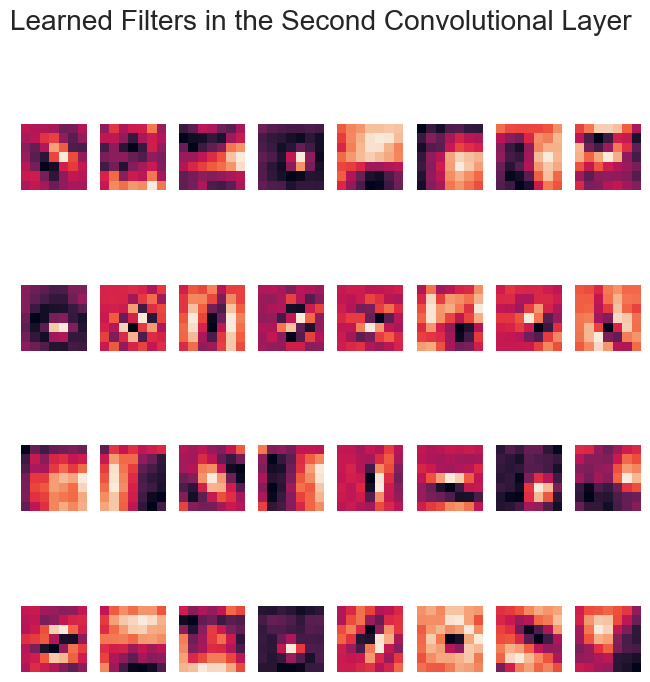

In [51]:
# Extract the filters from the second convolutional layer
filters = pretrained_resnet50.layers[2].get_weights()[0]

# Visualize the learned filters
# Learned Filters:
# The first part of the code visualizes the learned filters from the first convolutional layer. Each filter is a small matrix 
# of weights that slides over the input image, capturing different features.

plt.figure(figsize=(8, 8))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(filters[:, :, 0, i])
    plt.axis('off')
plt.suptitle('Learned Filters in the Second Convolutional Layer')
plt.show()

https://en.wikipedia.org/wiki/Zero-shot_learning

In [52]:
import json
from urllib import request

# Download the label mapping file
url = "https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json"
response = request.urlopen(url)
data = json.loads(response.read())

# Create a dictionary to map class indices to labels
label_mapping = {int(idx): label for idx, (_, label) in data.items()}

# Print the label mapping
print(label_mapping)


{0: 'tench', 1: 'goldfish', 2: 'great_white_shark', 3: 'tiger_shark', 4: 'hammerhead', 5: 'electric_ray', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich', 10: 'brambling', 11: 'goldfinch', 12: 'house_finch', 13: 'junco', 14: 'indigo_bunting', 15: 'robin', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water_ouzel', 21: 'kite', 22: 'bald_eagle', 23: 'vulture', 24: 'great_grey_owl', 25: 'European_fire_salamander', 26: 'common_newt', 27: 'eft', 28: 'spotted_salamander', 29: 'axolotl', 30: 'bullfrog', 31: 'tree_frog', 32: 'tailed_frog', 33: 'loggerhead', 34: 'leatherback_turtle', 35: 'mud_turtle', 36: 'terrapin', 37: 'box_turtle', 38: 'banded_gecko', 39: 'common_iguana', 40: 'American_chameleon', 41: 'whiptail', 42: 'agama', 43: 'frilled_lizard', 44: 'alligator_lizard', 45: 'Gila_monster', 46: 'green_lizard', 47: 'African_chameleon', 48: 'Komodo_dragon', 49: 'African_crocodile', 50: 'American_alligator', 51: 'triceratops', 52: 'thunder_snake', 53: 'ringneck_snake', 54: 'hogn

1/1 [==============================] - 0s 87ms/step


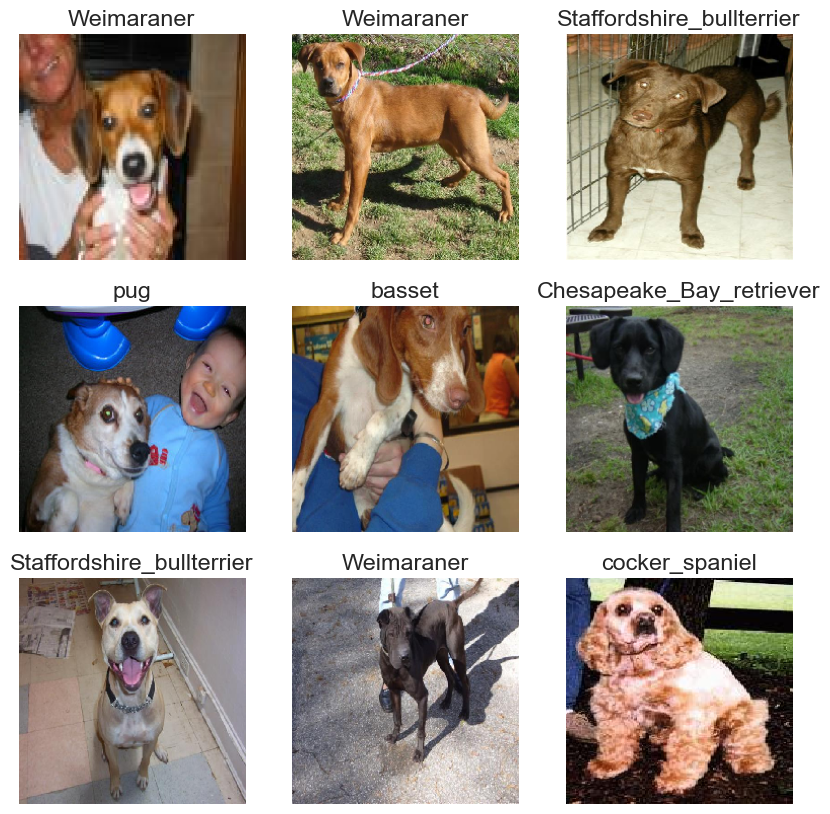

In [54]:
from keras.preprocessing import image

fnames = [
    os.path.join(test_dir + "/dogs", fname)
    for fname in os.listdir(test_dir + "/dogs")
]

plt.figure(figsize=(10, 10))
for i in range(9):
  img_path = fnames[i]
  img = image.load_img(img_path, target_size=(224, 224))

  x = image.img_to_array(img)
  x = x.reshape((1,) + x.shape)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image.array_to_img(x[0]))
  prediction = pretrained_resnet50.predict(x)[0]
  predicted_class = np.argmax(prediction, axis=0)
  predicted_label = label_mapping[predicted_class]

  plt.title(f"{predicted_label}")
  # plt.title(f"{predicted_lable}, {prediction}")
  plt.axis("off")

https://keras.io/api/applications/resnet/

https://www.analyticsvidhya.com/blog/2021/03/introduction-to-the-architecture-of-alexnet/

https://medium.com/@kyan7472/these-are-the-5-best-pre-trained-neural-networks-23798e61a043


In [76]:
train_data_224 = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224,224),
    batch_size=batch_size,
    color_mode="rgb",
    label_mode="binary"
)

validation_data_224 = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(224,224),
    batch_size=batch_size,
    color_mode="rgb",
    label_mode="binary"
)

Found 14997 files belonging to 2 classes.
Found 3706 files belonging to 2 classes.


In [86]:
validation_data_224.__dict__.keys()

dict_keys(['_input_dataset', '_buffer_size', '_name', '_variant_tensor_attr', '_graph_attr', '_options_attr', 'class_names', 'file_paths'])

### Finetuning
See this resource for more details: https://keras.io/guides/transfer_learning/

In [87]:
# finetune the ResNet
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense
from keras.optimizers.legacy import Adam

num_classes = 1  # for binary, use 1

# Load pretrained ResNet50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


# Freeze some layers
for layer in base_model.layers:
    layer.trainable = False
model_finetuned.classes = train_data_224.class_names

# Compile the model
model_finetuned.compile(optimizer=keras.optimizers.Adam(),
                        loss=keras.losses.BinaryCrossentropy(from_logits=True),
                        metrics=[keras.metrics.BinaryAccuracy()])

epochs = 5
# Train the model
model_finetuned.fit(
    train_data_224,
    epochs=epochs,
    validation_data=validation_data_224
)

Epoch 1/5


/Users/nataliakees/miniconda3/envs/python_data_env/lib/python3.11/site-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


130/469 [=======>......................] - ETA: 5:06 - loss: 0.0228 - binary_accuracy: 0.5091

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


165/469 [=========>....................] - ETA: 4:34 - loss: 0.0241 - binary_accuracy: 0.5063

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


253/469 [===============>..............] - ETA: 3:12 - loss: 0.0268 - binary_accuracy: 0.5023

261/469 [===============>..............] - ETA: 3:05 - loss: 0.0261 - binary_accuracy: 0.5026

KeyboardInterrupt: 

In [ ]:
# Optionally, fine-tuning by unfreezing some layers

"""
for layer in model.layers[:100]:
    layer.trainable = False
for layer in model.layers[100:]:
    layer.trainable = True

# Continue training
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(
    train_data_224,
    epochs=epochs,
    validation_data=validation_data_224
)
"""

## Object detection

https://keras.io/examples/vision/yolov8/

https://towardsdatascience.com/how-to-train-a-custom-object-detection-model-with-yolo-v5-917e9ce13208


## Pretrained CV models

https://github.com/onnx/models